# Chromatin Model Validation Metrics

## Heatmap-based metrics

### Signal distribution metric

In [1]:
import numpy as np
import hicstraw
from tqdm import tqdm
from scipy.spatial import distance
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
def get_coordinates_cif(file:str):
    '''
    It returns the corrdinate matrix V (N,3) of a .pdb file.
    The main problem of this function is that coordiantes are not always in 
    the same column position of a .pdb file. Do changes appropriatelly,
    in case that the data aren't stored correctly. 
    
    Input:
    file (str): the path of the .cif file.
    
    Output:
    V (np.array): the matrix of coordinates
    '''
    V = list()
    
    with open(file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if line.startswith("ATOM"):
                columns = line.split()
                x = eval(columns[10])
                y = eval(columns[11])
                z = eval(columns[12])
                V.append([x, y, z])
    
    return np.array(V)

def get_heat(V,viz=False):
    mat = distance.cdist(V, V, 'euclidean') # this is the way \--/
    mat = 1/(mat+1)**(1/3)

    if viz:
        figure(figsize=(15, 7))
        plt.imshow(mat,cmap="Reds",vmax=0.01)
        plt.show()
    return mat

def generate_random_walks(n_walks=950, n_steps=1000):
    """
    Generate `n_walks` random walk structures in 3D.
    
    Parameters:
    - n_walks (int): Number of random walks to generate.
    - n_steps (int): Number of steps in each random walk.

    Returns:
    - list of numpy arrays: Each array represents a random walk in 3D space.
    """
    walks = []
    heat = 0
    
    for _ in tqdm(range(n_walks)):
        steps = np.random.choice([-1, 1], size=(n_steps, 3))  # Random steps in x, y, z
        positions = np.cumsum(steps, axis=0)  # Compute cumulative positions
        heat += get_heat(positions)
        walks.append(positions)
    
    return walks, heat/n_walks

def remove_diagonal(matrix):
    """
    Removes the diagonal of a square matrix by setting it to zero.

    Parameters:
    - matrix (numpy.ndarray): A square matrix.

    Returns:
    - numpy.ndarray: The matrix with its diagonal elements set to zero.
    """
    if matrix.shape[0] != matrix.shape[1]:
        raise ValueError("Input must be a square matrix.")
    
    matrix_no_diag = matrix.copy()
    np.fill_diagonal(matrix_no_diag, 0)
    
    return matrix_no_diag
    
def remove_k_diagonals(matrix, k):
    N = len(matrix)
    reduced_matrix = np.zeros((N,N))
    reduced_matrix += np.tril(matrix,k=-k)
    reduced_matrix += np.triu(matrix,k=k)
    
    new_matrix = np.zeros((N-k+1,N-k))
    for i in range(k,N):
        for j in range(i-k+1):
            new_matrix[i-k+1,j] = reduced_matrix[i,j]
            new_matrix[j,i-k] = reduced_matrix[j,i]
    new_matrix = new_matrix[:N-k,:N-k]
    return np.array(new_matrix)

In [3]:
N = 1000
_, rd_heat = generate_random_walks(N,1000)
rd_heat = (rd_heat-np.min(rd_heat))/(np.max(rd_heat)-np.min(rd_heat))
rd_heat = remove_k_diagonals(rd_heat,50)

100%|███████████████████████████████████████████████████████████████████| 1000/1000 [00:30<00:00, 32.45it/s]


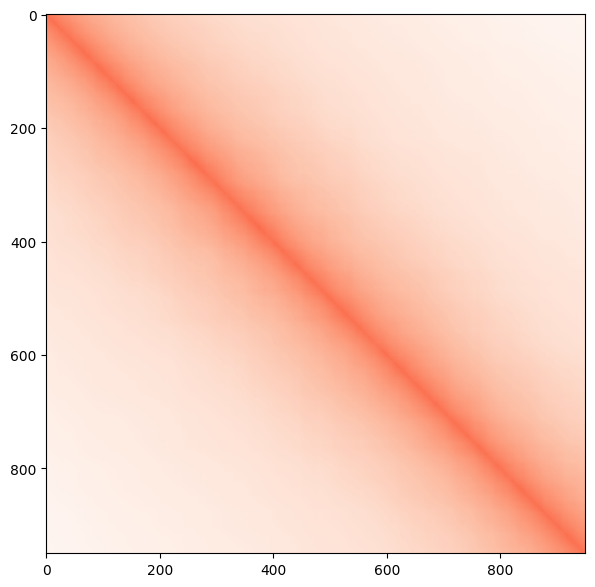

In [4]:
figure(figsize=(15, 7))
plt.imshow(rd_heat,cmap="Reds",vmax=0.5,vmin=0.0)
plt.show()

In [5]:
# V = get_coordinates_cif('/home/skorsak/Data/hackathon/results/MultiEM_HiC/MultiEM_minimized.cif')
# H = get_heat(V)
# H = remove_diagonal(H)
# H[H>0.01]=0.01

In [6]:
# H = 0
# for i in tqdm(range(N)):
#     V = get_coordinates_cif(f'/home/skorsak/Data/hackathon/MultiMM_ensemble/sample_{i+1}/MultiMM_minimized.cif')
#     H += get_heat(V)
# H = H/N
# H = (H-np.min(H))/(np.max(H)-np.min(H))
# H = remove_k_diagonals(H,50)

In [7]:
H = 0
for i in tqdm(range(1249-N,1249)):
    V = get_coordinates_cif(f'/home/skorsak/Data/hackathon/md_LEFs_80/ensemble/MDLE_{i+1}.cif')
    H += get_heat(V)
H = H/N
H = (H-np.min(H))/(np.max(H)-np.min(H))
H = remove_k_diagonals(H,50)

100%|███████████████████████████████████████████████████████████████████| 1000/1000 [00:58<00:00, 17.04it/s]


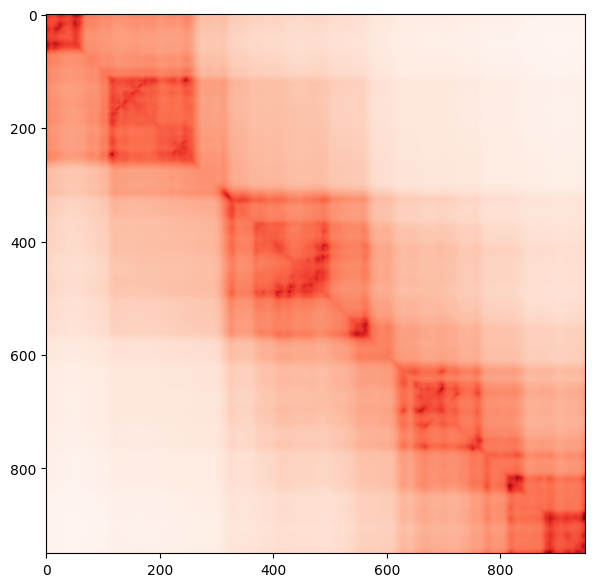

In [8]:
figure(figsize=(15, 7))
plt.imshow(H,cmap="Reds",vmax=0.5,vmin=0.0)
plt.show()

In [9]:
def average_signal_distance(matrix):
    """
    Calculate the average signal as a function of the distance from the diagonal for a 2D matrix.
    
    Parameters:
        matrix (numpy.ndarray): 2D array.
        
    Returns:
        numpy.ndarray: Array containing the average signal for each distance from the diagonal.
    """
    if not isinstance(matrix, np.ndarray) or matrix.ndim != 2:
        raise ValueError("Input must be a 2D numpy array.")
    
    rows, cols = matrix.shape
    max_distance = max(rows, cols)
    signal = np.zeros(max_distance, dtype=float)
    counts = np.zeros(max_distance, dtype=int)
    
    for i in range(rows):
        for j in range(cols):
            d = abs(j - i)
            signal[d] += matrix[i, j]
            counts[d] += 1

    # Avoid division by zero
    counts[counts == 0] = 1
    signal /= counts
    return signal

In [10]:
p_s = average_signal_distance(H)

In [11]:
def fit_power_law(distances, p_s):
    """
    Fit a power law p(s) = s^a to the array p_s and estimate the exponent a with error.
    
    Parameters:
        distances (numpy.ndarray): Array of distances from the diagonal (1D).
        p_s (numpy.ndarray): Array of average signals corresponding to distances (1D).
        
    Returns:
        tuple: Estimated exponent `a`, and its standard error.
    """
    if not isinstance(distances, np.ndarray) or not isinstance(p_s, np.ndarray):
        raise ValueError("Both distances and p_s must be numpy arrays.")
    if len(distances) != len(p_s):
        raise ValueError("Distances and p_s must have the same length.")
    if np.any(distances <= 0):
        raise ValueError("Distances must be positive to fit a power law.")
    
    # Power-law function
    def power_law(s, a, c):
        return c * s**a

    # Perform curve fitting
    try:
        popt, pcov = curve_fit(power_law, distances, p_s, p0=[1.0, 1.0], bounds=([-np.inf, 0], [np.inf, np.inf]))
        a, c = popt
        a_error = np.sqrt(np.diag(pcov))[0]  # Standard error for `a`
    except Exception as e:
        raise RuntimeError(f"Curve fitting failed: {e}")
    print(f'power is {a:.4f} with error +/-{a_error:.4f}')
    return a, a_error

In [12]:
s = np.arange(len(p_s))+1
a, a_error = fit_power_law(s, p_s)

power is -0.3659 with error +/-0.0078


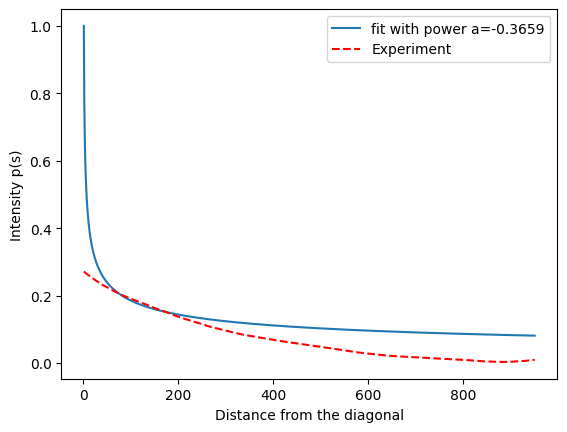

In [13]:
plt.plot(s,s**a,label=f'fit with power a={a:.4}')
plt.plot(s,p_s,'r--',label='Experiment')
plt.ylabel('Intensity p(s)')
plt.xlabel('Distance from the diagonal')
plt.legend()
plt.show()

In [14]:
hic = hicstraw.HiCFile("/home/skorsak/Data/4DNucleome/4DNFIC3JD6O2/4DNFIC3JD6O2.hic")
# hic = hicstraw.HiCFile("/home/skorsak/Data/method_paper_data/ENCSR184YZV_CTCF_ChIAPET/ENCFF379AWZ.hic")

In [15]:
matrix_object = hic.getMatrixZoomData('1', '1', "observed", "NONE", "BP", 2000)

In [16]:
hic_matrix = matrix_object.getRecordsAsMatrix(178421513,179491193,178421513,179491193)
hic_matrix = (hic_matrix - np.min(hic_matrix))/(np.max(hic_matrix) - np.min(hic_matrix))
hic_matrix = remove_k_diagonals(hic_matrix,50)

In [17]:
hic_matrix

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01980198, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01980198, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00990099,
        0.00990099],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00990099,
        0.00990099]])

In [18]:
p_s = average_signal_distance(hic_matrix)

In [19]:
p_s

array([4.11522634e-03, 4.09308972e-03, 4.13223140e-03, 4.18178464e-03,
       4.46777043e-03, 4.45647475e-03, 4.00165017e-03, 4.01000434e-03,
       3.99768010e-03, 3.79849306e-03, 3.88967468e-03, 3.93955185e-03,
       3.67631700e-03, 3.49569841e-03, 3.63945293e-03, 3.80483908e-03,
       3.51801138e-03, 3.44106905e-03, 3.27917407e-03, 3.26499459e-03,
       3.67568946e-03, 3.25774513e-03, 3.13673609e-03, 3.47496953e-03,
       3.47177575e-03, 3.43635231e-03, 3.20705984e-03, 3.13854915e-03,
       3.27510917e-03, 3.44476461e-03, 3.49574431e-03, 3.27494288e-03,
       3.53295241e-03, 3.52982318e-03, 3.16525015e-03, 3.11738491e-03,
       3.05830583e-03, 3.15332201e-03, 3.22666195e-03, 3.30033003e-03,
       3.21893176e-03, 2.87017466e-03, 2.83203996e-03, 2.95018215e-03,
       3.21446172e-03, 3.43503738e-03, 2.95904590e-03, 3.04472361e-03,
       3.08558253e-03, 2.65083717e-03, 2.69098011e-03, 2.82235120e-03,
       2.85166766e-03, 3.05261473e-03, 2.97946461e-03, 2.75665618e-03,
      

In [20]:
s = np.arange(len(p_s))+1
a, a_error = fit_power_law(s, p_s)

power is -0.3473 with error +/-0.0092


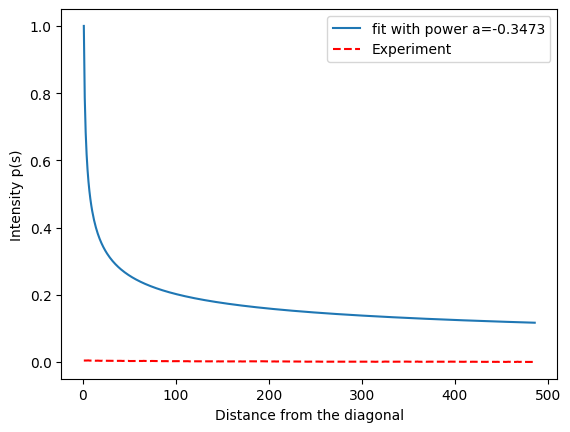

In [21]:
plt.plot(s,s**a,label=f'fit with power a={a:.4}')
plt.plot(s,p_s,'r--',label='Experiment')
plt.ylabel('Intensity p(s)')
plt.xlabel('Distance from the diagonal')
plt.legend()
plt.show()

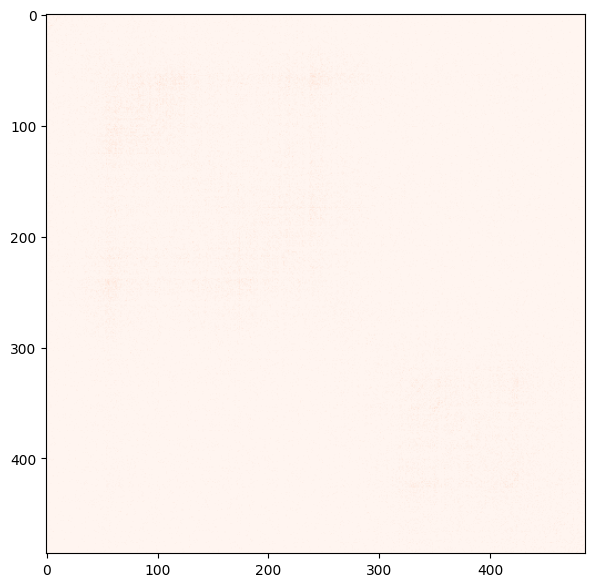

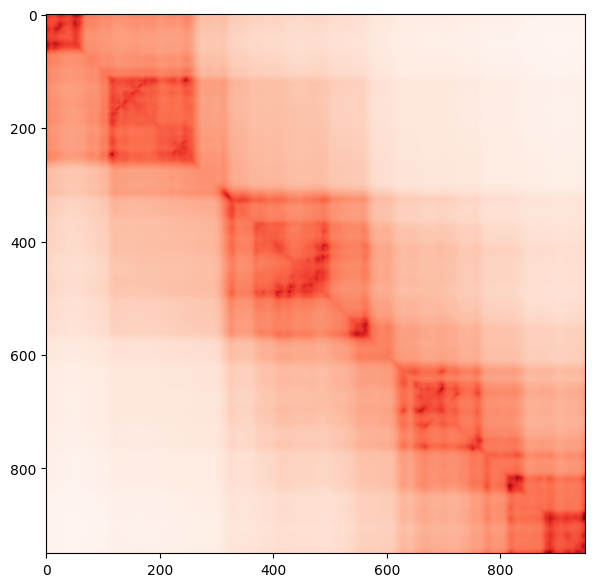

In [71]:
figure(figsize=(7, 7),dpi=100)
plt.imshow(hic_matrix,cmap='Reds',vmax=np.mean(hic_matrix)+np.std(hic_matrix))
plt.show()
figure(figsize=(15, 7))
plt.imshow(H,cmap="Reds",vmax=0.5,vmin=0.0)
plt.show()

### Correlations between heatmaps

In [23]:
from scipy.stats import pearsonr, spearmanr, kendalltau
from scipy.ndimage import gaussian_filter

def smooth_matrix(matrix, sigma=1.0):
    """
    Apply Gaussian smoothing to the input matrix.
    
    Parameters:
    - matrix: 2D numpy array to be smoothed.
    - sigma: Standard deviation for Gaussian kernel (controls smoothing extent).
    
    Returns:
    - Smoothed matrix.
    """
    return gaussian_filter(matrix, sigma=sigma)

def normalize_matrix(matrix, method="zscore"):
    """
    Normalize the input matrix using the specified method.
    Methods: 'zscore', 'minmax', 'log'
    """
    if method == "zscore":
        mean = np.mean(matrix)
        std = np.std(matrix)
        return (matrix - mean) / std
    elif method == "minmax":
        min_val = np.min(matrix)
        max_val = np.max(matrix)
        return (matrix - min_val) / (max_val - min_val)
    elif method == "log":
        return np.log1p(matrix)
    else:
        raise ValueError(f"Unknown normalization method: {method}")

def resize_matrix(larger, target_shape):
    """Resize the larger matrix to the target shape using averaging."""
    large_rows, large_cols = larger.shape
    target_rows, target_cols = target_shape

    row_scale = large_rows / target_rows
    col_scale = large_cols / target_cols

    # Create an output matrix
    resized = np.zeros((target_rows, target_cols))

    for i in range(target_rows):
        for j in range(target_cols):
            # Determine the bounds of the block in the original matrix
            row_start = int(i * row_scale)
            row_end = int((i + 1) * row_scale)
            col_start = int(j * col_scale)
            col_end = int((j + 1) * col_scale)

            # Average over the block
            resized[i, j] = np.mean(larger[row_start:row_end, col_start:col_end])

    return resized

def compute_metrics(matrix1, matrix2):
    """Compute various metrics between two matrices."""
    # Flatten the matrices
    m1_flat = matrix1.flatten()
    m2_flat = matrix2.flatten()
    # m1_flat = np.average(matrix1,axis=0)
    # m2_flat = np.average(matrix2,axis=0)

    # Pearson correlation
    pearson_corr, _ = pearsonr(m1_flat, m2_flat)

    # Spearman correlation
    spearman_corr, _ = spearmanr(m1_flat, m2_flat)

    # Kendall-Tau correlation
    kendall_corr, _ = kendalltau(m1_flat, m2_flat)

    # Mean Squared Error
    mse = np.mean((m1_flat - m2_flat) ** 2)

    return {
        "Pearson Correlation": pearson_corr,
        "Spearman Correlation": spearman_corr,
        "Kendall-Tau Correlation": kendall_corr,
        "Mean Squared Error": mse,
    }

def compare_heatmaps(hic_exp, hic_sim, sigma=10.0, normalization_method="zscore"):
    """Main function to compare Hi-C experimental and simulated heatmaps."""
    # Apply Gaussian smoothing to the experimental heatmap
    smoothed_exp = smooth_matrix(hic_exp, sigma=sigma)

    # Apply averaging to the bigger matrix to match th dimension of smaller
    if hic_exp.shape == hic_sim.shape:
        resized_exp, resized_sim = smoothed_exp, hic_sim
    elif hic_exp.size > hic_sim.size:
        resized_exp = resize_matrix(smoothed_exp, hic_sim.shape)
        resized_sim = hic_sim
    else:
        resized_sim = resize_matrix(hic_sim, smoothed_exp.shape)
        resized_exp = hic_exp

     # Normalize the matrices
    norm_exp = normalize_matrix(resized_exp, method=normalization_method)
    norm_sim = normalize_matrix(resized_sim, method=normalization_method)

    # Estimate correlation
    metrics = compute_metrics(norm_exp, norm_sim)
    return resized_exp, resized_sim, metrics

In [24]:
hic_new, rd_new, metrics = compare_heatmaps(hic_matrix, rd_heat)

In [25]:
metrics

{'Pearson Correlation': 0.20841124321743534,
 'Spearman Correlation': 0.20937150831703477,
 'Kendall-Tau Correlation': 0.16921586664529312,
 'Mean Squared Error': 1.5831775135651296}

In [26]:
hic_new, sim_new, metrics = compare_heatmaps(hic_matrix, H)

In [27]:
metrics

{'Pearson Correlation': 0.22646379853538606,
 'Spearman Correlation': 0.21948677595064647,
 'Kendall-Tau Correlation': 0.1775520131080975,
 'Mean Squared Error': 1.5470724029292275}

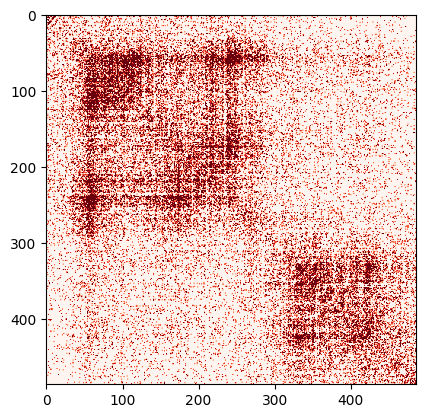

In [28]:
plt.imshow(hic_new,cmap='Reds',vmax=np.mean(hic_matrix)+np.std(hic_matrix))
plt.show()

In [29]:
p_s = average_signal_distance(hic_new)

In [30]:
s = np.arange(len(p_s))+1
a, a_error = fit_power_law(s, p_s)

power is -0.3473 with error +/-0.0092


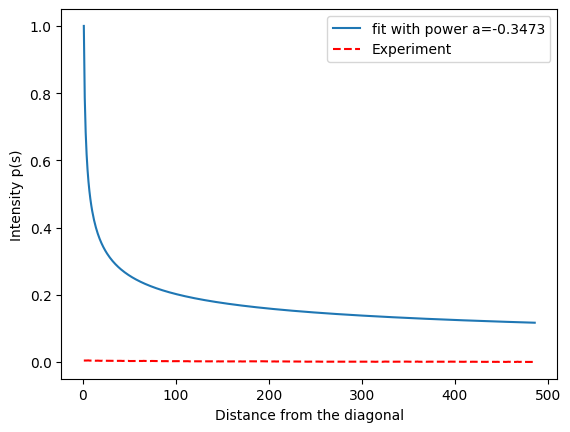

In [31]:
plt.plot(s,s**a,label=f'fit with power a={a:.4}')
plt.plot(s,p_s,'r--',label='Experiment')
plt.ylabel('Intensity p(s)')
plt.xlabel('Distance from the diagonal')
plt.legend()
plt.show()

# Fréchet inception distance (FID)
Fréchet Inception Distance (FID) is a metric used to measure the similarity between two sets of images, typically used to evaluate the quality of generated images compared to real images. It computes the Fréchet distance (also known as the Wasserstein-2 distance) between two multivariate Gaussian distributions estimated from the activations of an Inception model.

### How FID Works
1. **Feature Extraction:** Instead of comparing images pixel-wise, FID uses a deep network (such as Inception-v3) to extract feature representations.
2. **Gaussian Approximation:** The features are assumed to be normally distributed, and the mean and covariance are estimated.
3. **Computing Fréchet Distance:** Given two sets of features (real and generated), the Fréchet distance is computed as:

$$FID = ||\mu_1 - \mu_2||^2 + Tr(\Sigma_1 + \Sigma_2 - 2(\Sigma_1 \Sigma_2)^{1/2})$$

where:
- $\mu_1, \Sigma_1$ are the mean and covariance of the first distribution.
- $\mu_2, \Sigma_2$ are the mean and covariance of the second distribution.
- $Tr$ denotes the trace of a matrix.

### Application to 3C/Hi-C Heatmaps
Since FID is normally used for images, in this case, **matrix1** and **matrix2** represent heatmaps derived from 3C-based experiments (like Hi-C). These heatmaps can be treated as feature representations of chromatin interactions. We will calculate FID directly from these matrices assuming they are already extracted feature maps.

In [32]:
import cv2
from scipy.linalg import sqrtm
from skimage.metrics import structural_similarity as ssim

def calculate_fid(matrix1, matrix2):
    """
    Compute the Fréchet Inception Distance (FID) between two heatmaps.

    Parameters:
    matrix1 (numpy.ndarray): First matrix representing a 3C/Hi-C heatmap.
    matrix2 (numpy.ndarray): Second matrix representing a 3C/Hi-C heatmap.

    Returns:
    float: The FID score.
    """
    # Compute the mean and covariance of each matrix
    mu1, sigma1 = np.mean(matrix1, axis=0), np.cov(matrix1, rowvar=False)
    mu2, sigma2 = np.mean(matrix2, axis=0), np.cov(matrix2, rowvar=False)

    # Compute squared difference of means
    mean_diff = np.sum((mu1 - mu2) ** 2)

    # Compute sqrt of product of covariance matrices
    cov_sqrt = sqrtm(sigma1 @ sigma2)
    
    # Handle numerical issues
    if np.iscomplexobj(cov_sqrt):
        cov_sqrt = cov_sqrt.real

    # Compute FID score
    fid_score = mean_diff + np.trace(sigma1 + sigma2 - 2 * cov_sqrt)
    
    return fid_score

def compute_ssim(matrix1, matrix2):
    """
    Compute the Structural Similarity Index (SSIM) between two heatmaps.

    Parameters:
    matrix1 (numpy.ndarray): First heatmap.
    matrix2 (numpy.ndarray): Second heatmap.

    Returns:
    float: SSIM score (-1 to 1, higher is better).
    """
    return ssim(matrix1, matrix2, data_range=matrix2.max() - matrix2.min())

def compute_gmsd(matrix1, matrix2):
    """
    Compute the Gradient Magnitude Similarity Deviation (GMSD) between two heatmaps.

    Parameters:
    matrix1 (numpy.ndarray): First heatmap.
    matrix2 (numpy.ndarray): Second heatmap.

    Returns:
    float: GMSD score (lower means more similar).
    """
    # Compute gradients
    gx1 = cv2.Sobel(matrix1, cv2.CV_64F, 1, 0, ksize=3)
    gy1 = cv2.Sobel(matrix1, cv2.CV_64F, 0, 1, ksize=3)
    gx2 = cv2.Sobel(matrix2, cv2.CV_64F, 1, 0, ksize=3)
    gy2 = cv2.Sobel(matrix2, cv2.CV_64F, 0, 1, ksize=3)

    # Compute gradient magnitudes
    g1 = np.sqrt(gx1**2 + gy1**2)
    g2 = np.sqrt(gx2**2 + gy2**2)

    # Compute GMS
    C = 0.0026  # Small stability constant
    gms_map = (2 * g1 * g2 + C) / (g1**2 + g2**2 + C)
    
    # Compute standard deviation
    gmsd_value = np.std(gms_map)

    return gmsd_value

In [33]:
fid_value = calculate_fid(hic_new, rd_new)
print("FID Score:", fid_value)

FID Score: 5.277658856219428


In [34]:
fid_value = calculate_fid(hic_new, sim_new)
print("FID Score:", fid_value)

FID Score: 9.082599397164746


In [35]:
compute_ssim(hic_new, rd_new)

0.03618309535177211

In [36]:
compute_ssim(hic_new, sim_new)

0.06198686315759864

In [37]:
compute_gmsd(hic_new, rd_new)

0.09773110679642895

In [38]:
compute_gmsd(hic_new, sim_new)

0.14235319796348397

In [39]:
def compute_phase_correlation(matrix1, matrix2):
    """
    Compute the phase correlation similarity between two heatmaps.

    Parameters:
    matrix1 (numpy.ndarray): First heatmap.
    matrix2 (numpy.ndarray): Second heatmap.

    Returns:
    float: Peak phase correlation value (higher means more similar).
    """
    f1 = np.fft.fft2(matrix1)
    f2 = np.fft.fft2(matrix2)

    cross_power = (f1 * np.conj(f2)) / np.abs(f1 * np.conj(f2))  # Normalize
    correlation = np.fft.ifft2(cross_power).real

    return np.max(correlation)  # Peak similarity

In [40]:
phase_corr_score = compute_phase_correlation(hic_new, rd_new)
print("Phase Correlation Score:", phase_corr_score)

Phase Correlation Score: 0.01575663678252194


In [41]:
phase_corr_score = compute_phase_correlation(hic_new, sim_new)
print("Phase Correlation Score:", phase_corr_score)

Phase Correlation Score: 0.015232158755264817


In [42]:
def compute_canny_similarity(matrix1, matrix2, threshold1=0.2, threshold2=0.7):
    """
    Compute edge-based similarity between two heatmaps using Canny edge detection.

    Parameters:
    matrix1 (numpy.ndarray): First heatmap.
    matrix2 (numpy.ndarray): Second heatmap.
    threshold1 (int): Lower threshold for Canny.
    threshold2 (int): Upper threshold for Canny.

    Returns:
    float: Percentage of overlapping edges (higher is better).
    """
    edges1 = cv2.Canny((matrix1 * 255).astype(np.uint8), threshold1, threshold2)
    edges2 = cv2.Canny((matrix2 * 255).astype(np.uint8), threshold1, threshold2)

    intersection = np.sum((edges1 > 0) & (edges2 > 0))
    union = np.sum((edges1 > 0) | (edges2 > 0))

    return intersection / union if union > 0 else 0

In [43]:
compute_canny_similarity(hic_new, rd_new)

0.12194298495494925

In [44]:
compute_canny_similarity(hic_new, sim_new)

0.11876761384103575

FID Score: 8.330834031175602 for LoopSage

FID Score: 3.4878041753150537 for MultiMM

## Perform Statistical Tests

1. Mantel Test (Correlation Between Two Distance Matrices)
- Measures the similarity between two distance matrices (Hi-C contact map vs. 3D distance matrix).
- Uses permutation testing to assess statistical significance.

2. Kullback-Leibler (KL) Divergence
- Compares the probability distributions of Hi-C contact frequencies and the inverse 3D distances.

3. Jensen-Shannon (JS) Divergence
- A symmetric version of KL divergence, providing a bounded similarity measure between two distributions.

4. Earth Mover’s Distance (Wasserstein Distance)
- Compares the empirical distributions of pairwise distances.

5. Chi-Square Test
- Compares observed vs. expected distance distributions.

6. Bhattacharyya Coefficient
- Measures overlap between two probability distributions.

## **Summary of Each Test**
| **Test** | **What It Measures** | **Expected Outcome** |
|----------|----------------------|----------------------|
| **Mantel Test** | Correlation between Hi-C and 3D distance matrices | High correlation (~0.8) if structure is valid |
| **KL Divergence** | How different the Hi-C and inverse 3D distance distributions are | Lower is better (~<0.5) |
| **JS Divergence** | Symmetric distance between distributions | Lower is better (~<0.3) |
| **Earth Mover's Distance** | How much one distribution must be shifted to match the other | Lower is better |
| **Chi-Square Test** | Whether two distance distributions are statistically different | Higher p-value (>0.05) means similarity |
| **Bhattacharyya Coefficient** | Overlap between two distributions (higher is better) | Closer to 1 means similar distributions |

---

### **Use Case**
- If the **Mantel test** correlation is high (p < 0.05), then the structure is consistent with Hi-C.
- If **KL and JS divergence** values are low, it means the 3D structure captures Hi-C contact frequencies well.
- If the **Chi-square test** p-value is high, then the distance distributions are statistically similar.
- A high **Bhattacharyya coefficient** means the distance distributions are closely matched.

---

### **Final Thoughts**
These tests provide multiple validation perspectives:
1. **Structural similarity** (Mantel, Pearson, Spearman)
2. **Probability distributions** (KL, JS, Bhattacharyya)
3. **Physical significance** (Earth Mover's Distance, Chi-Square Test)

In [45]:
import scipy.spatial.distance as ssd
import scipy.stats as stats
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import jensenshannon
from sklearn.metrics import pairwise_distances

# 1. Mantel Test (Correlation Between Hi-C and Simulated Distance Matrices)
def mantel_test(distance_matrix, expected_dist_matrix, num_permutations=1000):
    """
    Compute the Mantel test between the simulated distance matrix and the expected one.

    Parameters:
    - distance_matrix (numpy.ndarray): Simulated 3D structure distance matrix.
    - expected_dist_matrix (numpy.ndarray): Expected distance matrix (derived from experimental Hi-C).
    - num_permutations (int): Number of permutations for significance testing.

    Returns:
    - observed_corr (float): Pearson correlation coefficient.
    - p_value (float): Significance of the correlation.
    """
    # Ensure diagonals are zero
    np.fill_diagonal(distance_matrix, 0)
    np.fill_diagonal(expected_dist_matrix, 0)

    # Make sure matrices are symmetric
    distance_matrix = (distance_matrix + distance_matrix.T) / 2
    expected_dist_matrix = (expected_dist_matrix + expected_dist_matrix.T) / 2

    # Convert to condensed form
    dist1 = ssd.squareform(distance_matrix)
    dist2 = ssd.squareform(expected_dist_matrix)

    # Compute observed Pearson correlation
    observed_corr = stats.pearsonr(dist1, dist2)[0]
    
    # Permutation test
    permuted_corrs = []
    for _ in range(num_permutations):
        permuted_indices = np.random.permutation(len(dist2))
        permuted_corr = stats.pearsonr(dist1, dist2[permuted_indices])[0]
        permuted_corrs.append(permuted_corr)

    # Compute p-value
    p_value = np.sum(np.abs(permuted_corrs) >= np.abs(observed_corr)) / num_permutations

    return observed_corr, p_value

# 2. Kullback-Leibler (KL) Divergence
def kl_divergence(distance_matrix, expected_dist_matrix):
    p_hist, _ = np.histogram(distance_matrix[np.triu_indices_from(distance_matrix, k=1)], bins=20, density=True)
    q_hist, _ = np.histogram(expected_dist_matrix[np.triu_indices_from(expected_dist_matrix, k=1)], bins=20, density=True)

    return stats.entropy(p_hist + 1e-10, q_hist + 1e-10)  # Avoid log(0)

# 3. Jensen-Shannon (JS) Divergence
def js_divergence(distance_matrix, expected_dist_matrix):
    p_hist, _ = np.histogram(distance_matrix[np.triu_indices_from(distance_matrix, k=1)], bins=20, density=True)
    q_hist, _ = np.histogram(expected_dist_matrix[np.triu_indices_from(expected_dist_matrix, k=1)], bins=20, density=True)

    return jensenshannon(p_hist, q_hist)

# 4. Earth Mover’s Distance (Wasserstein Distance)
def earth_movers_distance(distance_matrix, expected_dist_matrix):
    p_hist, _ = np.histogram(distance_matrix[np.triu_indices_from(distance_matrix, k=1)], bins=20, density=True)
    q_hist, _ = np.histogram(expected_dist_matrix[np.triu_indices_from(expected_dist_matrix, k=1)], bins=20, density=True)

    return wasserstein_distance(p_hist, q_hist)

# 5. Chi-Square Test
def chi_square_test(distance_matrix, expected_dist_matrix):
    p_hist, _ = np.histogram(distance_matrix[np.triu_indices_from(distance_matrix, k=1)], bins=20, density=True)
    q_hist, _ = np.histogram(expected_dist_matrix[np.triu_indices_from(expected_dist_matrix, k=1)], bins=20, density=True)

    # Normalize histograms to have the same sum
    p_hist = p_hist / np.sum(p_hist)
    q_hist = q_hist / np.sum(q_hist)

    return stats.chisquare(p_hist + 1e-10, q_hist + 1e-10)  # Avoid log(0)

# 6. Bhattacharyya Coefficient
def bhattacharyya_coefficient(distance_matrix, expected_dist_matrix):
    p_hist, _ = np.histogram(distance_matrix[np.triu_indices_from(distance_matrix, k=1)], bins=20, density=True)
    q_hist, _ = np.histogram(expected_dist_matrix[np.triu_indices_from(expected_dist_matrix, k=1)], bins=20, density=True)

    return np.sum(np.sqrt(p_hist * q_hist))

# 7. KS Test (Kolmogorov-Smirnov)
def ks_test_distance_distribution(distance_matrix, expected_dist_matrix):
    sim_distances = np.sort(distance_matrix[np.triu_indices_from(distance_matrix, k=1)])
    expected_distances = np.sort(expected_dist_matrix[np.triu_indices_from(expected_dist_matrix, k=1)])

    ks_stat, p_value = stats.ks_2samp(sim_distances, expected_distances)
    return ks_stat, p_value

In [46]:
mantel_corr, mantel_p = mantel_test(sim_new, hic_new)
kl_div = kl_divergence(sim_new, hic_new)
js_div = js_divergence(sim_new, hic_new)
emd = earth_movers_distance(sim_new, hic_new)
chi2_stat, chi2_p = chi_square_test(sim_new, hic_new)
b_coeff = bhattacharyya_coefficient(sim_new, hic_new)
ks_stat, ks_p_value = ks_test_distance_distribution(sim_new, hic_new)

# Print results
print(f"Mantel Test: Correlation={mantel_corr:.3f}, p-value={mantel_p}")
print(f"KL Divergence: {kl_div:.3f}")
print(f"JS Divergence: {js_div:.3f}")
print(f"Earth Mover’s Distance: {emd:.3f}")
print(f"Chi-Square Test: Statistic={chi2_stat:.3f}, p-value={chi2_p}")
print(f"Bhattacharyya Coefficient: {b_coeff:.3f}")
print(f"KS Test Statistic: {ks_stat:.3f}, p-value={ks_p_value}")

Mantel Test: Correlation=0.298, p-value=0.0
KL Divergence: 15.231
JS Divergence: 0.598
Earth Mover’s Distance: 14.603
Chi-Square Test: Statistic=593153735.949, p-value=0.0
Bhattacharyya Coefficient: 55.755
KS Test Statistic: 0.944, p-value=0.0


In [47]:
mantel_corr, mantel_p = mantel_test(rd_new, hic_new)
kl_div = kl_divergence(rd_new, hic_new)
js_div = js_divergence(rd_new, hic_new)
emd = earth_movers_distance(rd_new, hic_new)
chi2_stat, chi2_p = chi_square_test(rd_new, hic_new)
b_coeff = bhattacharyya_coefficient(rd_new, hic_new)
ks_stat, ks_p_value = ks_test_distance_distribution(rd_new, hic_new)

# Print results
print(f"Mantel Test: Correlation={mantel_corr:.3f}, p-value={mantel_p}")
print(f"KL Divergence: {kl_div}")
print(f"JS Divergence: {js_div}")
print(f"Earth Mover’s Distance: {emd}")
print(f"Chi-Square Test: Statistic={chi2_stat}, p-value={chi2_p}")
print(f"Bhattacharyya Coefficient: {b_coeff}")
print(f"KS Test Statistic: {ks_stat}, p-value={ks_p_value}")

Mantel Test: Correlation=0.274, p-value=0.0
KL Divergence: 17.186948079691145
JS Divergence: 0.7204878171233023
Earth Mover’s Distance: 16.237132416565213
Chi-Square Test: Statistic=427682584.1451022, p-value=0.0
Bhattacharyya Coefficient: 51.2378867976625
KS Test Statistic: 0.9539688600398795, p-value=0.0


In [48]:
from scipy.spatial import procrustes

def procrustes_test(matrix1, matrix2):
    """
    Perform Procrustes analysis to compare similarity between two matrices.

    Parameters:
    - matrix1, matrix2 (numpy.ndarray): Two matrices of the same shape.

    Returns:
    - float: Procrustes similarity score (lower means more similarity).
    """
    if matrix1.shape != matrix2.shape:
        raise ValueError("Matrices must have the same shape.")

    mtx1, mtx2, disparity = procrustes(matrix1, matrix2)
    return disparity

In [49]:
procrustes_test(sim_new, hic_new)

0.8223867939791777

In [50]:
procrustes_test(rd_new, hic_new)

0.8058588215014574

In [51]:
from scipy.spatial.distance import pdist, squareform

def distance_correlation(X, Y):
    """
    Compute the distance correlation between two matrices.

    Parameters:
    - X, Y (numpy.ndarray): Two matrices.

    Returns:
    - float: Distance correlation (higher means more similarity).
    """
    def distance_matrix(A):
        return squareform(pdist(A, metric='euclidean'))

    def centering_matrix(D):
        n = D.shape[0]
        J = np.eye(n) - np.ones((n, n)) / n
        return J @ D @ J

    A = distance_matrix(X)
    B = distance_matrix(Y)

    A_centered = centering_matrix(A)
    B_centered = centering_matrix(B)

    dcov_XY = np.sqrt(np.sum(A_centered * B_centered) / (X.shape[0] ** 2))
    dcov_XX = np.sqrt(np.sum(A_centered * A_centered) / (X.shape[0] ** 2))
    dcov_YY = np.sqrt(np.sum(B_centered * B_centered) / (X.shape[0] ** 2))

    return dcov_XY / np.sqrt(dcov_XX * dcov_YY)

In [52]:
distance_correlation(sim_new, hic_new)

0.6939266519037655

In [53]:
distance_correlation(rd_new, hic_new)

0.6894870509297781

In [54]:
from sklearn.cross_decomposition import CCA

def rv_coefficient(matrix1, matrix2):
    """
    Compute the RV coefficient (a measure of similarity between two matrices).

    Parameters:
    - matrix1, matrix2 (numpy.ndarray): Two matrices of the same shape.

    Returns:
    - float: RV coefficient (higher means more similarity).
    """
    if matrix1.shape != matrix2.shape:
        raise ValueError("Matrices must have the same shape.")

    numerator = np.trace(matrix1.T @ matrix2 @ matrix2.T @ matrix1)
    denominator = np.sqrt(np.trace(matrix1.T @ matrix1 @ matrix1.T @ matrix1) *
                          np.trace(matrix2.T @ matrix2 @ matrix2.T @ matrix2))
    
    return numerator / denominator

In [55]:
rv_coefficient(sim_new, hic_new)

0.7960463908861167

In [56]:
rv_coefficient(rd_new, hic_new)

0.7888485732323159

Here the results look pretty bad :(

## Stratified Distance Correlations

Instead of computing a **single correlation** between the **simulated** and **experimental** distances, **DSCC** measures correlations **separately for different genomic distance bins**.

- In Hi-C and 3D genome modeling, **short-range interactions** (nearby loci) often have **higher accuracy** than long-range ones.
- **DSCC helps identify biases**—for example, if the simulation works well for **short-range contacts** but diverges for **long-range contacts**.

**Mathematically, we compute Pearson/Spearman correlation in separate genomic distance bins:**

$$\rho(s) = \text{correlation}( d_{ij}^{\text{sim}}, d_{ij}^{\text{exp}} \mid |i - j| = s )$$

where:
- $d_{ij}^{\text{sim}}$ = Simulated 3D distance between loci $i, j$.
- $d_{ij}^{\text{exp}}$ = Experimental Hi-C-derived 3D distance.
- $s$ = Genomic separation $|i - j|$ (i.e., how far apart loci are on the linear genome).

In [57]:
def compute_dscc(simulated_matrix, experimental_matrix, bin_size=5):
    """Compute distance-stratified correlation coefficients."""
    N = simulated_matrix.shape[0]
    max_distance = N // 2  # Avoid redundant comparisons
    genomic_distances = np.arange(1, max_distance, bin_size)
    
    pearson_correlations = []
    spearman_correlations = []

    for s in genomic_distances:
        indices = [(i, i + s) for i in range(N - s)]  # Select all pairs at distance s
        sim_distances = np.array([simulated_matrix[i, j] for i, j in indices])
        exp_distances = np.array([experimental_matrix[i, j] for i, j in indices])

        # Compute correlations if we have enough points
        if len(sim_distances) > 5:
            pearson_corr = stats.pearsonr(sim_distances, exp_distances)[0]
            spearman_corr = stats.spearmanr(sim_distances, exp_distances)[0]
        else:
            pearson_corr, spearman_corr = np.nan, np.nan  # Not enough data

        pearson_correlations.append(pearson_corr)
        spearman_correlations.append(spearman_corr)

    return genomic_distances, pearson_correlations, spearman_correlations

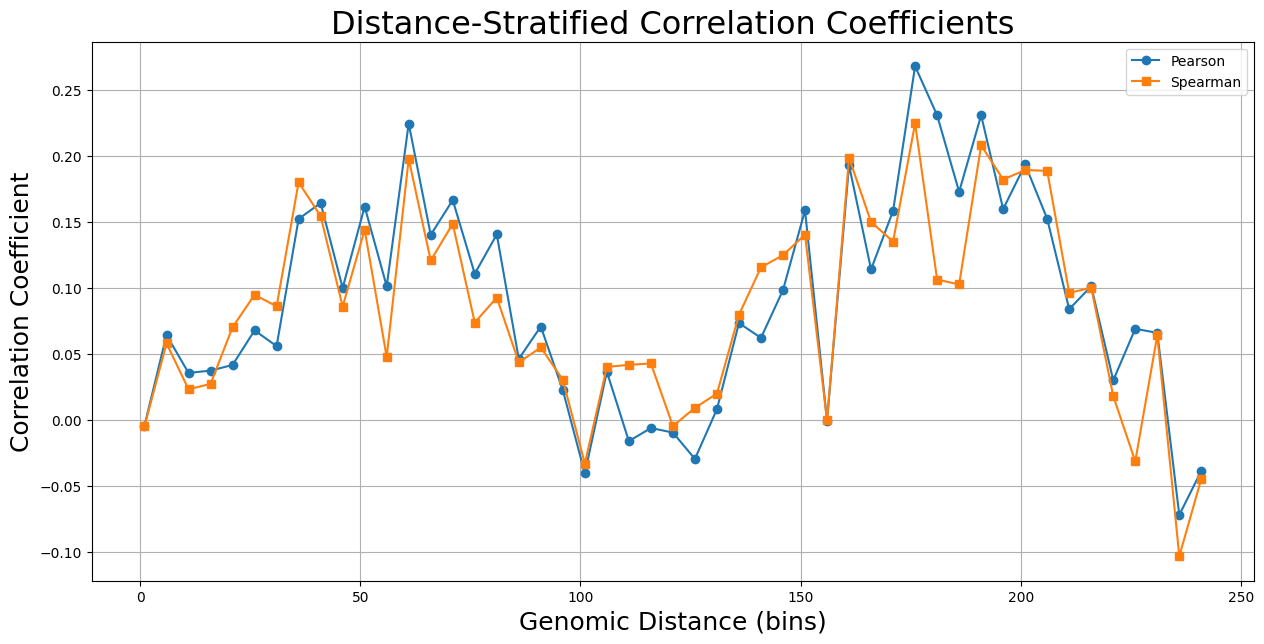

In [58]:
# Example usage
genomic_distances, pearson_corrs, spearman_corrs = compute_dscc(sim_new, hic_new)

# Plot results
plt.figure(figsize=(15, 7))
plt.plot(genomic_distances, pearson_corrs, label="Pearson", marker="o")
plt.plot(genomic_distances, spearman_corrs, label="Spearman", marker="s")
plt.xlabel("Genomic Distance (bins)",fontsize=18)
plt.ylabel("Correlation Coefficient",fontsize=18)
plt.legend()
plt.title("Distance-Stratified Correlation Coefficients",fontsize=23)
plt.grid()
plt.show()

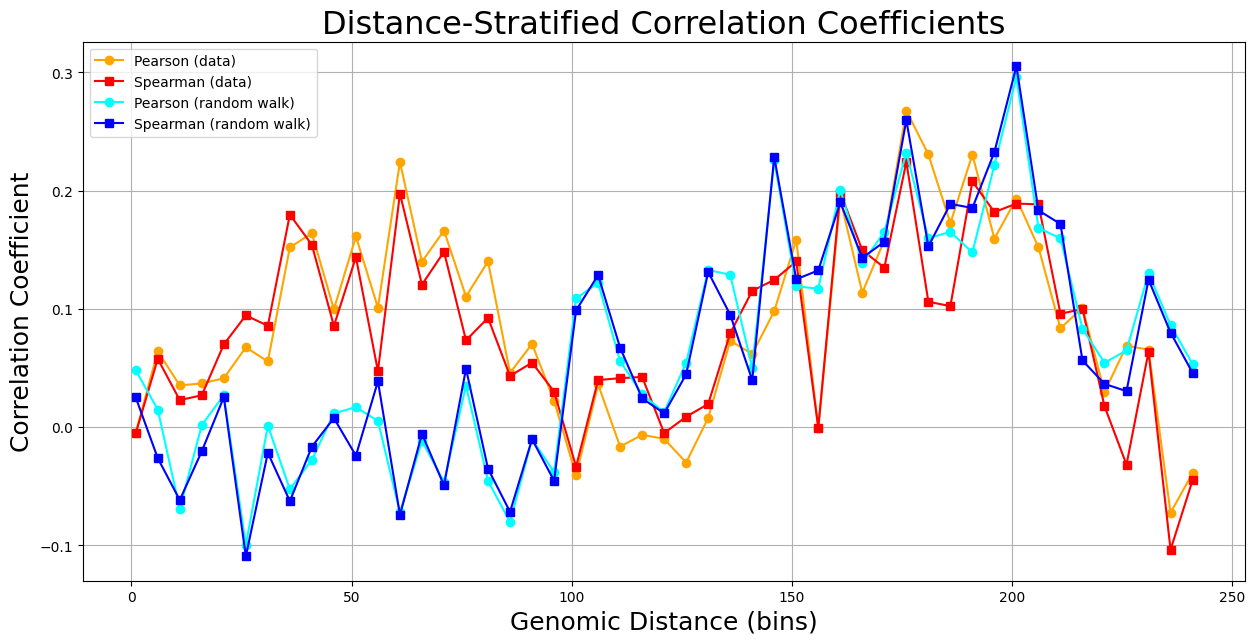

In [59]:
# Example usage
genomic_distances, pearson_corrs_rd, spearman_corrs_rd = compute_dscc(rd_new, hic_new)

# Plot results
plt.figure(figsize=(15, 7))
plt.plot(genomic_distances, pearson_corrs, label="Pearson (data)", marker="o" , color='orange')
plt.plot(genomic_distances, spearman_corrs, label="Spearman (data)", marker="s", color='red')
plt.plot(genomic_distances, pearson_corrs_rd, label="Pearson (random walk)", marker="o" , color='cyan')
plt.plot(genomic_distances, spearman_corrs_rd, label="Spearman (random walk)", marker="s", color='blue')
plt.xlabel("Genomic Distance (bins)",fontsize=18)
plt.ylabel("Correlation Coefficient",fontsize=18)
plt.legend()
plt.title("Distance-Stratified Correlation Coefficients",fontsize=23)
plt.grid()
plt.show()

## GenomeDISCO approach

Here we use the following method:

* Convert the adjacency matrix AA into a transition probability matrix $P$.
* Compute $P^t$, where tt is the optimal number of steps.
* Use $P^t$ as the denoised contact map.

You're right to question that. Normalizing by row sums introduces bias, especially in cases where node degrees vary significantly. A better approach is to use the **random walk with restart normalization** or the **symmetric normalization** to avoid this bias.

Here are two better ways to normalize the adjacency matrix:

* **Symmetric Normalization** (Preferred for Spectral Methods)
Instead of row-normalizing $A$, use the **degree-normalized Laplacian** approach:

$$P = D^{-1/2} A D^{-1/2}$$

where $D$ is the degree matrix, i.e., $D_{ii} = \sum_j A_{ij}$. This normalization ensures that we don't introduce directional bias.

* **Column-Stochastic Normalization** (Random Walk Perspective)
Instead of dividing by row sums, divide by **column sums** to make the matrix column-stochastic, which represents a **Markov process**.


In [60]:
def symmetric_normalization(A):
    """ Symmetric normalization: P = D^(-1/2) A D^(-1/2) """
    D = np.diag(1.0 / np.sqrt(A.sum(axis=1) + 1e-10))  # Avoid division by zero
    return D @ A @ D  # Equivalent to D^(-1/2) * A * D^(-1/2)

def column_stochastic_normalization(A):
    """ Column-stochastic normalization: P = A * D^(-1) where D is column sum matrix """
    col_sums = A.sum(axis=0, keepdims=True) + 1e-10  # Avoid division by zero
    return A / col_sums

def denoise_contact_map(A, t, method="symmetric"):
    """ Denoising using random walks with either symmetric or column normalization """
    if method == "symmetric":
        P = symmetric_normalization(A)
    elif method == "column":
        P = column_stochastic_normalization(A)
    else:
        raise ValueError("Unknown normalization method. Use 'symmetric' or 'column'.")

    P_t = np.linalg.matrix_power(P, t)  # Compute P^t
    return P_t

t = 3  # Number of steps in the random walk

denoised_sim = denoise_contact_map(sim_new, t)
denoised_hic = denoise_contact_map(hic_new, t)
denoised_rd = denoise_contact_map(rd_new, t)

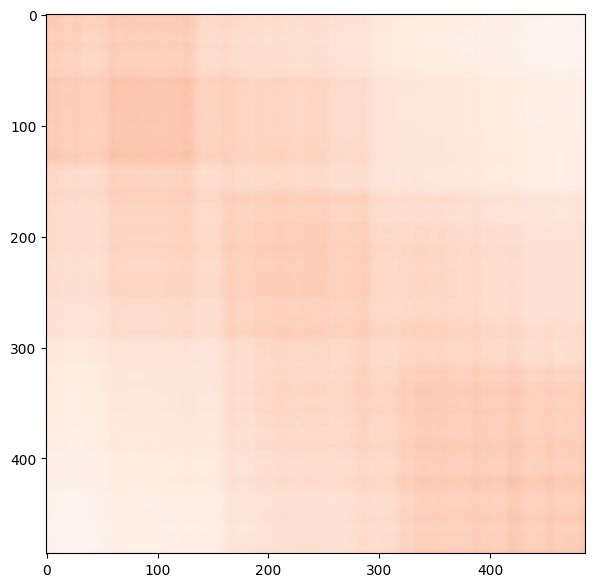

In [61]:
figure(figsize=(15, 7))
plt.imshow(denoised_sim,cmap="Reds",vmax=0.01)
plt.show()

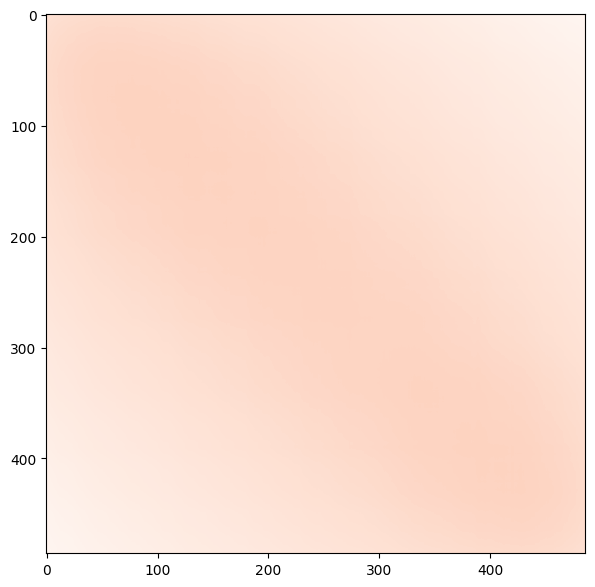

In [62]:
figure(figsize=(15, 7))
plt.imshow(denoised_rd,cmap="Reds",vmax=0.01)
plt.show()

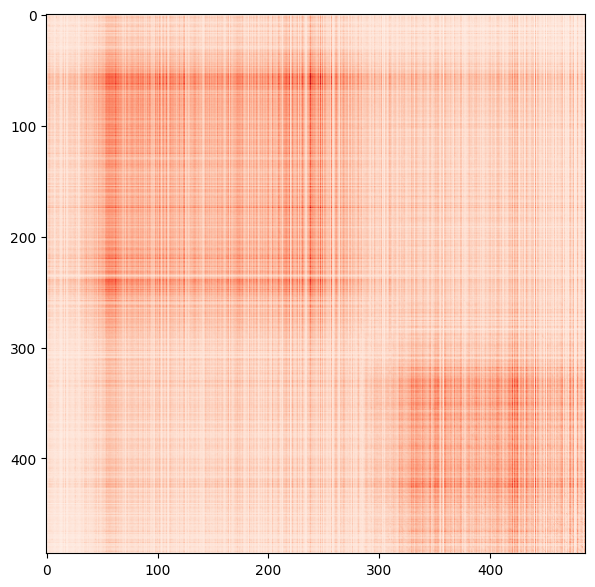

In [63]:
figure(figsize=(15, 7))
plt.imshow(denoised_hic,cmap="Reds",vmax=0.01)
plt.show()

In [64]:
def compute_L1_difference(A1, A2):
    """ Compute the L1 distance between denoised contact maps A1 and A2. """
    # Count nonzero nodes in the original matrices
    N_nonzero = 0.5 * (np.count_nonzero(A1.sum(axis=1)) + np.count_nonzero(A2.sum(axis=1)))
    
    # Compute L1 distance
    L1_distance = np.sum(np.abs(A1 - A2)) / N_nonzero
    return L1_distance

def compute_concordance_score(A1, A2):
    """ Compute the concordance score R based on L1 difference. """
    L1_diff = compute_L1_difference(A1, A2)
    return 1 - L1_diff

In [65]:
# Compute similarity metrics
L1_diff = compute_L1_difference(denoised_sim, denoised_hic)
concordance_score = compute_concordance_score(denoised_sim, denoised_hic)

print(f"L1 Difference: {L1_diff}")
print(f"Concordance Score: {concordance_score}")

L1 Difference: 0.2819213758144804
Concordance Score: 0.7180786241855196


In [66]:
# Compute similarity metrics
L1_diff = compute_L1_difference(denoised_rd, denoised_hic)
concordance_score = compute_concordance_score(denoised_rd, denoised_hic)

print(f"L1 Difference: {L1_diff}")
print(f"Concordance Score: {concordance_score}")

L1 Difference: 0.2796410373868018
Concordance Score: 0.7203589626131982


## HiCRep approach


The SCC is derived from the **Cochran–Mantel–Haenszel (CMH) statistic** and adjusts the Pearson correlation coefficient within each stratum. The formula for **$M^2$** is:

$$M^2 = \frac{\left( \sum_k N_k \rho_k \right)^2}{\sum_k N_k \text{Var}(T_k)}$$

Where:
- $k$ indexes the strata (bins),
- $N_k$ is the number of observations in stratum $k$,
- $\rho_k$ is the Pearson correlation coefficient within stratum $k$,
- $T_k$ is the sum of products of $X_k$ and $Y_k$,
- $\text{Var}(T_k)$ is the variance of $T_k$.

In [67]:
from scipy.ndimage import uniform_filter

def mean_filter_smoothing(contact_map, h):
    """
    Applies 2D mean filter smoothing to a contact map.
    
    Args:
        contact_map (numpy array): The original contact map (n x n matrix).
        h (int): The smoothing window size parameter.
        
    Returns:
        numpy array: The smoothed contact map.
    """
    kernel_size = 1 + 2 * h  # Compute the smoothing window size
    smoothed_map = uniform_filter(contact_map, size=kernel_size, mode='nearest')
    return smoothed_map

In [68]:

def define_strata_from_matrices(matrix_shape, bin_size):
    """
    Generate strata (distance bins) based on matrix indices.
    
    Args:
        matrix_shape (tuple): Shape of the contact map matrix (n, n).
        bin_size (int): Bin size for stratification.

    Returns:
        numpy array: Stratum indices for each pair (i, j).
    """
    n = matrix_shape[0]
    strata = np.zeros((n, n), dtype=int)
    
    for i in range(n):
        for j in range(n):
            distance = abs(i - j)  # Compute genomic distance
            strata[i, j] = distance // bin_size  # Assign to bin
    
    return strata

def compute_scc(A1, A2, bin_size):
    """
    Compute the Stratum-Adjusted Correlation Coefficient (SCC) 
    using the CMH-based statistical approach.
    
    Args:
        A1 (numpy array): Contact map matrix for sample 1.
        A2 (numpy array): Contact map matrix for sample 2.
        bin_size (int): Bin size for stratification.
    
    Returns:
        float: SCC statistic (M^2), which should be in [-1,1].
    """
    assert A1.shape == A2.shape, "Matrices must have the same dimensions!"
    
    strata = define_strata_from_matrices(A1.shape, bin_size)
    unique_strata = np.unique(strata)
    
    N_k = []
    r_1k, r_2k = [], []
    rho_k = []
    var_Tk = []
    
    for k in unique_strata:
        mask = (strata == k)
        X_k = A1[mask]
        Y_k = A2[mask]
        N_k.append(len(X_k))

        if len(X_k) > 1:
            # Compute T_k
            T_k = np.sum(X_k * Y_k)
            
            # Compute E(T_k)
            E_Tk = (np.sum(X_k) * np.sum(Y_k)) / len(X_k)

            # Compute var(T_k)
            r1k = np.sum(X_k*Y_k)/len(X_k) - np.sum(X_k)*np.sum(Y_k)/len(X_k)**2
            r_1k.append(r1k)
            var_Xk = np.sum(X_k**2)/len(X_k)-(np.sum(X_k)/len(X_k))**2
            var_Yk = np.sum(Y_k**2)/len(Y_k)-(np.sum(Y_k)/len(Y_k))**2
            r2k = np.sqrt(var_Xk*var_Yk)
            r_2k.append(r2k)
            var_Tk_value = 1 / (len(X_k) - 1)*(np.sum(X_k**2)-np.sum(X_k)**2/len(X_k))*(np.sum(Y_k**2)-np.sum(Y_k)**2/len(Y_k)) if len(X_k) > 1 else 0
            var_Tk.append(var_Tk_value)
            rhok = r1k/r2k
        else:
            rhok = 0
            var_Tk.append(0)

        rho_k.append(rhok)

    N_k = np.array(N_k)
    r_1k, r_2k = np.array(r_1k), np.array(r_2k)
    rho_k = np.array(rho_k)
    var_Tk = np.array(var_Tk)

    # Compute rho_s as a weighted sum
    numerator = np.sum(N_k * r_2k * rho_k)
    denominator = np.sum(N_k * r_2k)
    rho_s = numerator / denominator if denominator != 0 else 0

    # Compute M^2 statistic
    M2 = (rho_s**2) * np.sum((N_k*r_2k)**2) / np.sum((N_k*r_2k)**2/(N_k-1)) if np.sum(N_k) != 0 else 0
    
    return M2, rho_s

In [69]:
compute_scc(sim_new, hic_new, 100)

(1347.4864568046994, 0.12635881609682784)

In [70]:
compute_scc(rd_new, hic_new, 100)

(656.1215042823478, 0.08756550391090466)